IMPORTING LIBRARIES

In [ ]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense, Activation, Dropout, RepeatVector
from tensorflow.keras.optimizers import  RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

LOADING THE DATA

In [ ]:
#Loading the data
path = '/content/Next Word Prediction Dataset.txt'
text = open(path,encoding = "utf8").read().lower()
print('corpus length:', len(text))

corpus length: 581888


PREPROCESSING THE DATA

In [ ]:
character = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(character))
indices_char = dict((i, c) for i, c in enumerate(character))
 
print(f'unique chars: {len(character)}')

unique chars: 73


In [ ]:
seq_len = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - seq_len, step):
    sentences.append(text[i: i + seq_len ])
    next_chars.append(text[i + seq_len])
print(f'num training examples: {len(sentences)}')

num training examples: 193950


In [ ]:
X = np.zeros((len(sentences), seq_len, len(character)), dtype=np.bool)
y = np.zeros((len(sentences), len(character)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

sentences[124]
next_chars[100]

<ipython-input-17-b837ced14d63>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.zeros((len(sentences), seq_len, len(character)), dtype=np.bool)
<ipython-input-17-b837ced14d63>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(sentences), len(character)), dtype=np.bool)


'e'

In [ ]:
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True])

In [ ]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

SHAPE OF THE DATA

In [ ]:
X.shape

(193950, 40, 73)

In [ ]:
y.shape

(193950, 73)

MODEL CREATION

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(seq_len, len(character))))
model.add(Dense(len(character)))
model.add(Activation('softmax'))

GETTING THE SUMMARY OF THE MODEL

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               103424    
                                                                 
 dense (Dense)               (None, 73)                9417      
                                                                 
 activation (Activation)     (None, 73)                0         
                                                                 
Total params: 112,841
Trainable params: 112,841
Non-trainable params: 0
_________________________________________________________________


TRAINING THE MODEL

In [ ]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y,
                    validation_split=0.01, 
                    batch_size=128,
                    epochs=7, 
                    shuffle=True).history

Epoch 1/7
1501/1501 [==============================] - 179s 117ms/step - loss: 2.0237 - accuracy: 0.4077 - val_loss: 2.2584 - val_accuracy: 0.3763
Epoch 2/7
1501/1501 [==============================] - 173s 115ms/step - loss: 1.6540 - accuracy: 0.5036 - val_loss: 2.0243 - val_accuracy: 0.4139
Epoch 3/7
1501/1501 [==============================] - 174s 116ms/step - loss: 1.5337 - accuracy: 0.5381 - val_loss: 1.9620 - val_accuracy: 0.4567
Epoch 4/7
1501/1501 [==============================] - 178s 118ms/step - loss: 1.4711 - accuracy: 0.5548 - val_loss: 1.8844 - val_accuracy: 0.4763
Epoch 5/7
1501/1501 [==============================] - 175s 117ms/step - loss: 1.4308 - accuracy: 0.5645 - val_loss: 1.8590 - val_accuracy: 0.4711
Epoch 6/7
1501/1501 [==============================] - 174s 116ms/step - loss: 1.4007 - accuracy: 0.5731 - val_loss: 1.8671 - val_accuracy: 0.4918
Epoch 7/7
1501/1501 [==============================] - 175s 117ms/step - loss: 1.3803 - accuracy: 0.5788 - val_loss: 1

SAVING THE MODEL

In [ ]:
model.save('NW_keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

LOADING OUR MODEL

In [ ]:
model = load_model('NW_keras_model.h5')
history = pickle.load(open("history.p", "rb"))

EVALUATING THE MODEL

In [ ]:
loss_and_acc=model.evaluate(X,y)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])

6061/6061 [==============================] - 138s 23ms/step - loss: 1.3350 - accuracy: 0.5877
Test Loss 1.3349573612213135
Test Accuracy 0.5876772403717041


PLOTTING THE TRAINING AND VALIDATION PLOTS

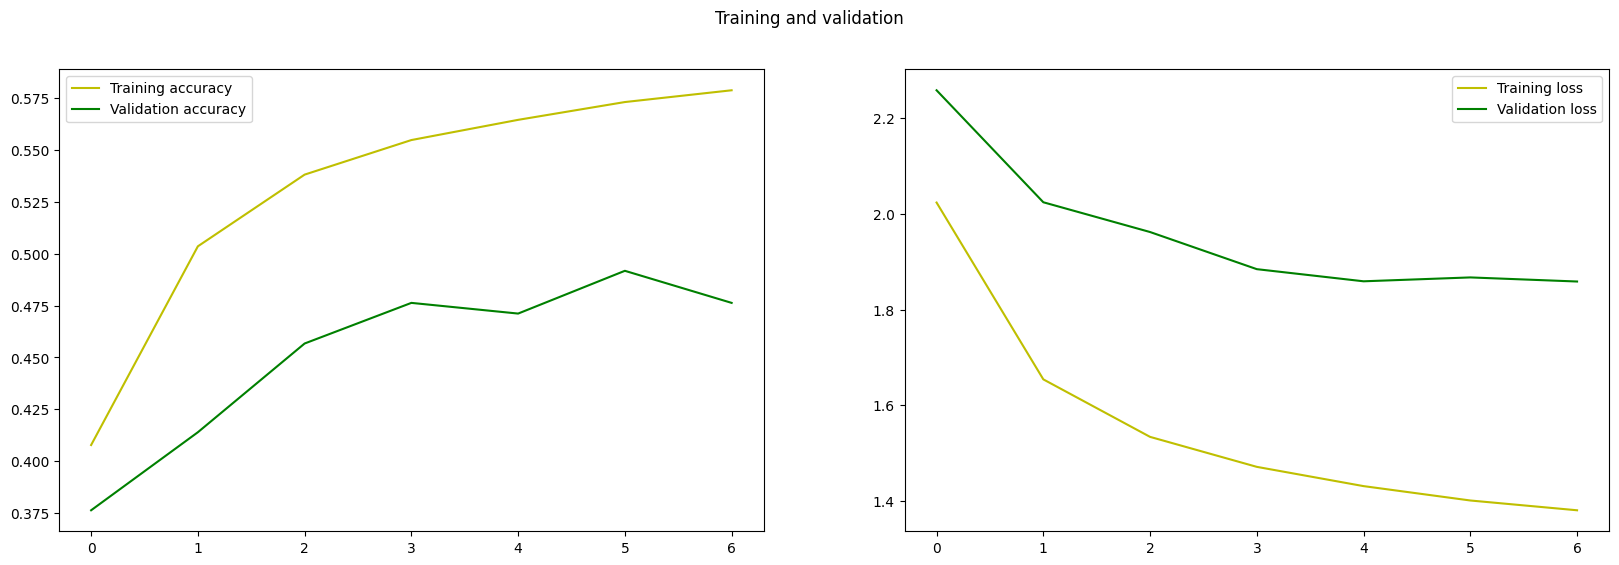

In [ ]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'y', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'g', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'y', label='Training loss')
ax[1].plot(epochs, val_loss, 'g', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

In [ ]:
def prepare_input(text):
    x = np.zeros((1, seq_len, len(character)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

prepare_input("This is an example of input of our model".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

FUNCTIONS TO GET FURTHER CHARACTERS

In [ ]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [ ]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [ ]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

PREDICTION

In [ ]:
quotes = [   
    "Deep learning is a branch of machine learning which is based on artificial neural networks.",
    "It is capable of learning complex patterns and relationships within data.",
    "In deep learning, we don’t need to explicitly program everything. It has become increasingly popular in recent years due to the advances in processing power and the availability of large datasets.",
    "Because it is based on artificial neural networks (ANNs) also known as deep neural networks (DNNs).",
    "These neural networks are inspired by the structure and function of the human brain’s biological neurons, and they are designed to learn from large amounts of data."  
    
]

In [ ]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

deep learning is a branch of machine lea
['d ', 'st ', 've ', 'ge ', 'ning ']

it is capable of learning complex patter
['ed ', 'al ', ' at ', 'ing ', '. ']

in deep learning, we don’t need to expli
['se ', 'ce ', 've ', 'ed ', 'nation ']

because it is based on artificial neural
[' the ', 'ly ', '\nstreng ', '. ', 'ity ']

these neural networks are inspired by th
['e ', 'is ', 'at ', 'ree ', 'ought ']

